# Demo for Universal Kriging implementation

This terminology is borrowed from this paper 
https://arxiv.org/pdf/2408.02331

1. Simple Kriging: Known mean function, no noise
2. Ordinary Kriging: Unknown constant mean, no noise
3. Universal Kriging: Unknown mean as linear combination of known functions



In [1]:
from autoemulate.simulations.projectile import Projectile

projectile = Projectile(log_level="error")
n_samples = 50
x = projectile.sample_inputs(n_samples).float()
y = projectile.forward_batch(x).float()
x.shape, y.shape

(torch.Size([50, 2]), torch.Size([50, 1]))

In [2]:
from autoemulate import AutoEmulate 
from autoemulate.emulators import GaussianProcess


# define custom mean 
for example here we try to incorporates some knowledge of projectile motion physics into the GP. With drag, there is no simple closed form solution and simulaiton is solved numerically. for no drag : $ R = v_0^2 sin(2\theta)/g$ 

cutom_mean is returning the `mean_module.PartiallyLearnableMean` class which has `projectile_mean` mean_func

and we replace `mean_module.partially_learnable_mean`

In [3]:
import autoemulate.emulators.gaussian_process.mean as mean_module

def projectile_mean(x):
    return x**2/9.8

def custom_mean(n_features, n_outputs):
    return mean_module.PartiallyLearnableMean(
        mean_func=projectile_mean,
        known_dim=0,
        input_size=n_features,
        batch_shape=n_outputs
    )

mean_module.partially_learnable_mean = custom_mean


This means that here , 

```python 
    return {
        "mean_module_fn": [
            constant_mean,
            zero_mean,
            linear_mean,
            poly_mean,
            partially_learnable_mean,
        ],
```

it itterates over these and our updated `partially_learnable_mean` and choose the best, as here the result is not the best for `partially_learnable_mean` I also check this for a case without tuning 

In [4]:
ae = AutoEmulate(x, y, models=[GaussianProcess], log_level="error")

In [5]:
ae.summarise()

,model_name,x_transforms,y_transforms,params,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,GaussianProcess,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function zero_mean at 0x33...,422.48349,0.666555,1.902998,0.999891,0.000173


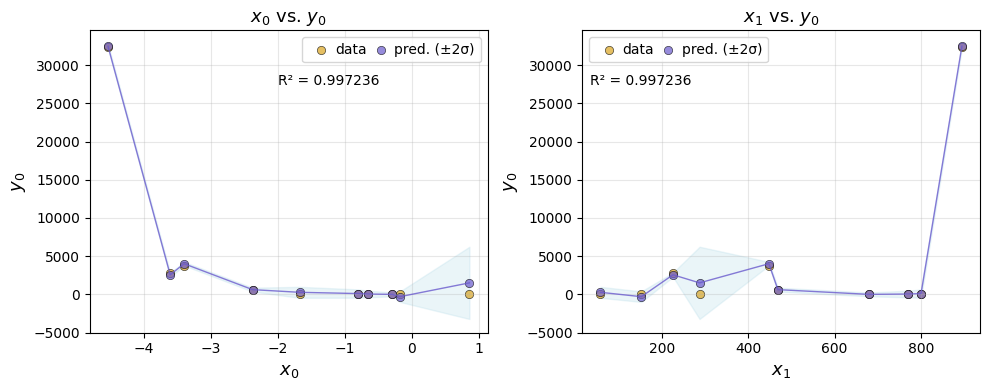

In [6]:
ae.plot(0)


# No tuning 
here ` mean_module.partially_learnable_mean` is forced without tuning 

In [7]:

ae_2 = AutoEmulate(
    x, y, 
    models=[GaussianProcess],
    model_tuning=False,
    model_params={"mean_module_fn": mean_module.partially_learnable_mean},
    log_level="error"
)

In [8]:
ae_2.summarise()

,model_name,x_transforms,y_transforms,params,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,GaussianProcess,[StandardizeTransform()],[StandardizeTransform()],{'mean_module_fn': <function custom_mean at 0x...,362.603912,-87.338058,283.28241,0.999891,0.000077


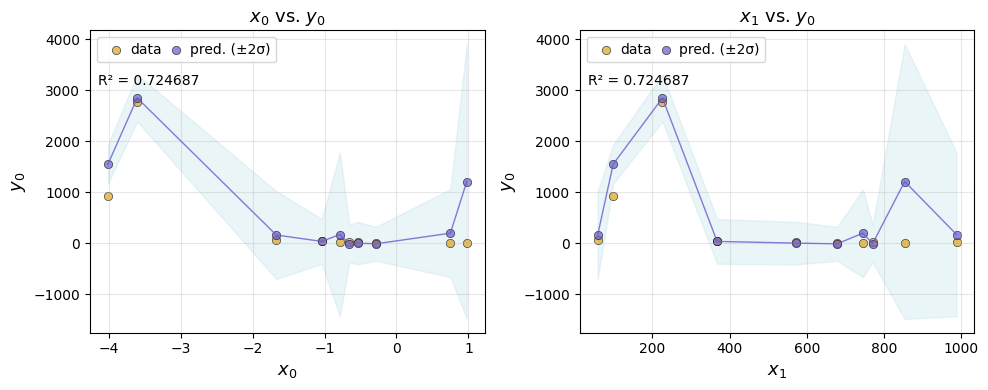

In [9]:
ae_2.plot(0)